In [ ]:
import itertools
import random
from collections import defaultdict

import numpy as np
import torch
import torch.nn.functional as F
from networkx.algorithms.centrality import degree_centrality
from scipy.stats import entropy
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *

import torch
import torch.nn.functional as F
import numpy as np
from torch import Tensor
from typing import Optional, Tuple, Union, Callable
from torch_geometric.utils import to_networkx, from_networkx

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx


# Function to convert torch_geometric Data object to NetworkX graph
def pyg_to_nx(data):
    return to_networkx(data, to_undirected=True)


# Function to convert NetworkX graph to torch_geometric Data object
def nx_to_pyg(G):
    return from_networkx(G)


# Function to implement MCSplit algorithm
def mc_split(G1, G2):
    # Step 1: Initialization
    incumbent = []
    max_size = 0

    # Step 2: Recursive search
    def search(mapping, future, incumbent):
        nonlocal max_size
        if len(mapping) > max_size:
            max_size = len(mapping)
            incumbent = mapping[:]
        bound = len(mapping) + sum(min(len(g), len(h)) for g, h in future)
        if bound <= max_size:
            return incumbent
        # Select label class
        G, H = min(future, key=lambda x: max(len(x[0]), len(x[1])))
        v = max(G, key=lambda x: G1.degree[x])
        for w in H:
            future_prime = []
            for G_prime, H_prime in future:
                G_prime_adj = [u for u in G_prime if u != v and u in G1.neighbors(v)]
                H_prime_adj = [u for u in H_prime if u != w and u in G2.neighbors(w)]
                if G_prime_adj and H_prime_adj:
                    future_prime.append((G_prime_adj, H_prime_adj))
                G_prime_non_adj = [
                    u for u in G_prime if u != v and u not in G1.neighbors(v)
                ]
                H_prime_non_adj = [
                    u for u in H_prime if u != w and u not in G2.neighbors(w)
                ]
                if G_prime_non_adj and H_prime_non_adj:
                    future_prime.append((G_prime_non_adj, H_prime_non_adj))
            incumbent = search(mapping + [(v, w)], future_prime, incumbent)
        G_prime = [u for u in G if u != v]
        future.remove((G, H))
        if G_prime:
            future.append((G_prime, H))
        incumbent = search(mapping, future, incumbent)
        return incumbent

    # Step 3: Start search with initial future and mapping
    future = [(list(G1.nodes), list(G2.nodes))]
    incumbent = search([], future, incumbent)

    return incumbent


# Function to find the maximum common subgraph between two torch_geometric graphs and return a dict of node mappings
def max_common_subgraph(data1, data2):
    G1 = pyg_to_nx(data1)
    G2 = pyg_to_nx(data2)
    mapping = mc_split(G1, G2)
    node_mapping = {v: w for v, w in mapping}
    return node_mapping

In [ ]:
def most_isomorphic(a_pyg, b_pyg):
    a = [to_networkx(g, to_undirected=True) for g in a_pyg]
    b = [to_networkx(g, to_undirected=True) for g in b_pyg]
    isomorphism_counts = [0] * len(a)
    for i, g1 in enumerate(a):
        for g2 in b:
            if nx.is_isomorphic(g1, g2):
                isomorphism_counts[i] += 1
    max_index = isomorphism_counts.index(max(isomorphism_counts))
    return a_pyg[max_index]


def find_min_total_ged_graph(graphs):
    nx_graphs = [to_networkx(graph, to_undirected=True) for graph in graphs]

    total_geds = [0] * len(nx_graphs)

    for i, graph_i in enumerate(nx_graphs):
        for j, graph_j in enumerate(nx_graphs):
            if i != j:
                min_ged = float("inf")
                for ged_estimate in nx.optimize_graph_edit_distance(graph_i, graph_j):
                    min_ged = min(min_ged, ged_estimate)
                total_geds[i] += min_ged

    min_ged_index = total_geds.index(min(total_geds))

    return graphs[min_ged_index]


def remove_double_edges(edge_index):
    edge_list = edge_index.t()
    unique_edges = torch.unique(edge_list, dim=0)
    return unique_edges.t()


def combine_graphs(graph1, graph2, mapping, ratio=0.5):
    x1, edge_index1 = graph1.x, graph1.edge_index
    x2, edge_index2 = graph2.x, graph2.edge_index

    new_x_size = x1.size(0) + x2.size(0) - len(mapping)
    new_x = torch.zeros((new_x_size, x1.size(1)))

    new_index_map = {}
    current_index = 0

    for idx1, idx2 in mapping.items():
        new_x[current_index] = (x1[idx1] + x2[idx2]) * ratio
        new_index_map[idx1] = current_index
        new_index_map[x1.size(0) + idx2] = current_index
        current_index += 1

    for idx1 in range(x1.size(0)):
        if idx1 not in mapping:
            new_x[current_index] = x1[idx1]
            new_index_map[idx1] = current_index
            current_index += 1

    for idx2 in range(x2.size(0)):
        if idx2 not in mapping.values():
            new_x[current_index] = x2[idx2]
            new_index_map[x1.size(0) + idx2] = current_index
            current_index += 1

    new_edge_list = []
    for edge in edge_index1.t():
        new_edge_list.append(
            [new_index_map[edge[0].item()], new_index_map[edge[1].item()]]
        )
    offset = x1.size(0)
    for edge in edge_index2.t():
        new_edge_list.append(
            [
                new_index_map[offset + edge[0].item()],
                new_index_map[offset + edge[1].item()],
            ]
        )

    new_edge_index = torch.tensor(new_edge_list).t().contiguous()

    clean_edge_index = remove_double_edges(new_edge_index)

    combined_graph = Data(x=new_x, edge_index=clean_edge_index)

    return combined_graph


def find_most_common_graph(graphs, k, model):

    k = min(k, len(graphs))

    def graph_hash(graph):
        G = to_networkx(graph, to_undirected=True)
        return tuple(sorted([d for n, d in G.degree()]))

    hash_counts = defaultdict(int)
    graph_by_hash = {}

    for graph in graphs:
        hash_val = graph_hash(graph)
        hash_counts[hash_val] += 1
        if hash_val not in graph_by_hash:
            graph_by_hash[hash_val] = graph

    most_common_hashes = sorted(hash_counts, key=hash_counts.get, reverse=True)[:k]
    most_common_graphs = [graph_by_hash[hash_key] for hash_key in most_common_hashes]

    if len(most_common_graphs) == 1:
        return most_common_graphs[0]

    combined_clusters = []

    for i in range(len(most_common_graphs)):
        for j in range(0, i):
            g1 = most_common_graphs[i]
            g2 = most_common_graphs[j]

            G1 = to_networkx(g1, to_undirected=True)
            G2 = to_networkx(g2, to_undirected=True)

            ismags = nx.isomorphism.ISMAGS(G1, G2)
            largest_common_subgraph = list(
                ismags.largest_common_subgraph(symmetry=False)
            )

            combined_graph = combine_graphs(g1, g2, largest_common_subgraph[0], 0.5)

            topk_pooling = TopKPooling(model.args.dim, ratio=k)
            combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
                topk_pooling(combined_graph.x, combined_graph.edge_index)
            )
            combined_clustered = Data(
                x=combined_clustered_x, edge_index=combined_clustered_edge_index
            )

            combined_clusters.append(combined_clustered)

    combined_hash_counts = defaultdict(int)
    combined_graph_by_hash = {}

    for graph in combined_clusters:
        hash_val = graph_hash(graph)
        combined_hash_counts[hash_val] += 1
        if hash_val not in combined_graph_by_hash:
            combined_graph_by_hash[hash_val] = graph

    most_common_combined_hash = max(combined_hash_counts, key=combined_hash_counts.get)
    most_common_combined_graph = combined_graph_by_hash[most_common_combined_hash]

    return most_common_combined_graph


def calculate_weighted_confidence(scores, external_weights=None, w_avg=0.5, w_var=0.5):
    average_score = scores.mean()

    variance_score = scores.var()

    if variance_score == 0:
        inverse_variance = torch.tensor(0)
    else:
        inverse_variance = 1 / variance_score

    weighted_confidence = w_avg * average_score + w_var * inverse_variance

    if external_weights is not None:
        weighted_confidence += external_weights.sum() * 0.1

    return weighted_confidence.item()


# def select_cluster(model, k_threshold=0.8):
#     accs = []
#     cs = []
#     clustered_graphs = []

#     k = best_k(model, k_threshold)

#     # k = 8

#     best_acc1, best_acc2 = 0.0, 0.0
#     cluster1, cluster2 = None, None
#     layer1, layer2 = None, None

#     layers = []
#     sims = []

#     for i in range(len(model.layer_outputs)):
#         (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

#         topk_pooling = TopKPooling(model.args.dim, ratio=8)

#         x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
#             x_1,
#             edge_index_1,
#         )
#         x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
#             x_2,
#             edge_index_2,
#         )

#         acc1 = len(set(range(8)) & set(perm1.tolist()))
#         acc2 = len(set(range(8)) & set(perm2.tolist()))

#         layers.append(
#             (
#                 (x_pooled_1, edge_index_pooled_1, score1),
#                 (x_pooled_2, edge_index_pooled_2, score2),
#                 i,
#             )
#         )

#         clustered_graphs.append(
#             (
#                 (
#                     Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
#                     # abs(score1).sum().item(),
#                     calculate_weighted_confidence(score1),
#                 ),
#                 (
#                     Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
#                     # abs(score2).sum().item(),
#                     calculate_weighted_confidence(score2),
#                 ),
#             )
#         )

#         if acc1 > best_acc1:
#             x = x_pooled_1
#             cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
#             best_acc1 = acc1
#             layer1 = i + 1
#         if acc2 > best_acc2:
#             cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
#             best_acc2 = acc2
#             layer2 = i + 1

#     cs.append((layers, layer1, layer2))

#     accs.append(best_acc1)
#     accs.append(best_acc2)

#     connected_1 = []
#     connected_2 = []
#     connected_pairs = []
#     all_clusters = []

#     for i in range(len(clustered_graphs)):
#         (g1, s1), (g2, s2) = clustered_graphs[i]
#         if nx.is_connected(to_networkx(g1, to_undirected=True)):
#             connected_1.append((g1, s1))
#         if nx.is_connected(to_networkx(g2, to_undirected=True)):
#             connected_2.append((g2, s2))

#         if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
#             to_networkx(g2, to_undirected=True)
#         ):
#             connected_pairs.append((g1, g2))
#         all_clusters.append((g1, s1))
#         all_clusters.append((g2, s2))

#     graphs = []

#     for i, (g1, s1) in enumerate(connected_1):
#         for j, (g2, s2) in enumerate(connected_2):
#             if nx.is_isomorphic(
#                 to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
#             ):
#                 graphs.append(
#                     (Data(x=(g1.x + g2.x) / 2, edge_index=g1.edge_index), i + 1, j + 1)
#                 )

#     # for graph in graphs:
#     # plot_graph(graph[0])

#     connected = connected_1 + connected_2
#     connected = sorted(connected, key=lambda x: x[1])

#     if graphs != []:
#         return (
#             find_most_common_graph([g[0] for g in graphs], 2, model),
#             k,
#             cluster1,
#             cluster2,
#             "isomorphic",
#             None,
#         )

#     elif connected != []:
#         connected_clustered = []
#         # for g1, s1 in connected_1:
#         #     for g2, s2 in connected_2:
#         #         # g1, g2 = connected_pairs[i]
#         #         G1 = to_networkx(g1, to_undirected=True)
#         #         G2 = to_networkx(g2, to_undirected=True)
#         #         ismags = nx.isomorphism.ISMAGS(G1, G2)
#         #         largest_common_subgraph = list(
#         #             ismags.largest_common_subgraph(symmetry=False)
#         #         )
#         #         # if nx.is_connected(G1) and nx.is_connected(G2):
#         #         combined_data = combine_graphs(
#         #             g1, g2, largest_common_subgraph[0], ratio=1
#         #         )

#         #         combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
#         #             topk_pooling(combined_data.x, combined_data.edge_index)
#         #         )

#         #         combined_clustered = Data(
#         #             x=combined_clustered_x, edge_index=combined_clustered_edge_index
#         #         )

#         #         # if nx.is_connected(to_networkx(combined_clustered, to_undirected=True)):
#         #         #     connected_clustered.append(combined_clustered)
#         #         if nx.is_isomorphic(
#         #             to_networkx(combined_clustered, to_undirected=True),
#         #             to_networkx(g1, to_undirected=True),
#         #         ) or nx.is_isomorphic(
#         #             to_networkx(combined_clustered, to_undirected=True),
#         #             to_networkx(g2, to_undirected=True),
#         #         ):
#         #             connected_clustered.append(combined_clustered)

#         return (
#             (
#                 find_most_common_graph(connected, 2, model)
#                 # random.choice(connected_clustered)
#                 if connected_clustered != []
#                 else find_most_common_graph([c[0] for c in connected], 2, model)
#             ),
#             k,
#             cluster1,
#             cluster2,
#             "connected_pair" if connected_clustered != [] else "connected",
#             connected_clustered,
#         )
#     elif connected_1 != [] or connected_2 != []:
#         return (
#             connected[0][0],
#             k,
#             cluster1,
#             cluster2,
#             "connected",
#             None,
#         )
#     else:
#         return (
#             random.choice(all_clusters)[0],
#             k,
#             cluster1,
#             cluster2,
#             "random",
#             None,
#         )

In [ ]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states


class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []
        self.topk_pooling = TopKPooling(self.args.dim, ratio=0.99)

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):

        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = self.topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = self.topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1, score1),
                    (x_pooled_2, edge_index_pooled_2, perm2, score2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        for i in range(len(self.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1, score1),
                (x_pooled_2, edge_index_pooled_2, perm2, score2),
            ) = self.topk_outputs[i]
            acc1 = len(set(range(8)) & set(perm1.tolist()))
            acc2 = len(set(range(8)) & set(perm2.tolist()))
            if acc1 > best_acc1:
                cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
                best_acc1 = acc1
                layer1 = i + 1
            if acc2 > best_acc2:
                cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
                best_acc2 = acc2
                layer2 = i + 1

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

In [ ]:
dataset = GraphDataset(torch.load("data/cycle_line_star_complete_1.pt"))

# dataset = TUDataset(
#     root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
# )

(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

In [ ]:
def train(model, optimizer, pairs, labels, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            # if i % 100 * batch_size == 0:
            #     print(
            #         f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
            #     )

    trained_params = get_params(model)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [ ]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def find_best_k(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        return k

    layer_scores_1 = []
    layer_scores_2 = []
    for i in range(len(model.topk_outputs)):
        (
            (_, _, _, score1),
            (_, _, _, score2),
        ) = model.topk_outputs[i]
        layer_scores_1.append(score1)
        layer_scores_2.append(score2)

    k_values_graph1 = []
    for i, scores in enumerate(layer_scores_1):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph1.append(best_k)

    k_values_graph2 = []
    for i, scores in enumerate(layer_scores_2):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph2.append(best_k)

    combined_ks = k_values_graph1 + k_values_graph2

    return (
        int(round(torch.mean(torch.tensor(combined_ks, dtype=float)).item())),
        k_values_graph1,
        k_values_graph2,
    )

In [ ]:
def acc_test(model, print_results=True, k_threshold=0.8):
    ks = []

    for j in range(100):
        for i in range(dataset.num_classes):
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(classes[c])), 1)[0]
            idx2 = random.sample(range(len(classes[c])), 1)[0]
            graph1, graph2 = classes[c][idx1], classes[c][idx2]

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
            )

            k, _, _ = best_k(model, k_threshold)

            ks.append(k)

    unique, counts = np.unique(ks, return_counts=True)
    results = dict(zip(unique, counts / 400))
    print(f"Selected k: {results}")

In [ ]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [ ]:
hyperparams = (32, 5, 0.2, 0.01, 64, 500)
newargs = NewArgs(*hyperparams)
model = GraphMatchingNetwork(newargs)
optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
train(model, optimizer, pairs, labels, newargs.batch_size)

In [ ]:
acc_test(model, True, 0.8)

In [ ]:
def compute_ged(g1, g2):
    # Placeholder function for computing Graph Edit Distance (GED)
    return nx.graph_edit_distance(
        to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
    )


def compute_feature_similarity(x1, x2):
    # Placeholder function for computing cosine similarity between node embeddings
    return torch.cosine_similarity(x1, x2, dim=1).mean().item()


def compute_attention_score(attn1, attn2):
    # Placeholder function for computing attention score
    return torch.sum(attn1 * attn2).item()

In [ ]:
# c = f"class_0"
# idx1 = random.sample(range(len(classes[c])), 1)[0]
# idx2 = random.sample(range(len(classes[c])), 1)[0]
# graph1, graph2 = classes[c][idx1], classes[c][idx2]

# model.eval()

# feats_1, edge_index_1 = graph1.x, graph1.edge_index
# feats_2, edge_index_2 = graph2.x, graph2.edge_index
# sizes_1 = torch.tensor([len(graph1.x)])
# sizes_2 = torch.tensor([len(graph2.x)])
# model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

# accs = []
# cs = []
# clustered_graphs = []

# k, k_1s, k_2s = best_k(model, 0.8)
# print(k)
# # k = 8

# best_acc1, best_acc2 = 0.0, 0.0
# cluster1, cluster2 = None, None
# layer1, layer2 = None, None

# layers = []
# sims = []

# for i in range(len(model.layer_outputs)):
#     (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

#     topk_pooling = TopKPooling(model.args.dim, ratio=8)

#     x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
#         x_1,
#         edge_index_1,
#     )
#     x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
#         x_2,
#         edge_index_2,
#     )

#     acc1 = len(set(range(8)) & set(perm1.tolist()))
#     acc2 = len(set(range(8)) & set(perm2.tolist()))

#     layers.append(
#         (
#             (x_pooled_1, edge_index_pooled_1, score1),
#             (x_pooled_2, edge_index_pooled_2, score2),
#             i,
#         )
#     )

#     clustered_graphs.append(
#         (
#             Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
#             Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
#         )
#     )

#     if acc1 > best_acc1:
#         x = x_pooled_1
#         cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
#         best_acc1 = acc1
#         layer1 = i + 1
#     if acc2 > best_acc2:
#         cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
#         best_acc2 = acc2
#         layer2 = i + 1

# cs.append((layers, layer1, layer2))

# accs.append(best_acc1)
# accs.append(best_acc2)

# connected_1 = []
# connected_2 = []
# connected_pairs = []
# all_clusters = []

# for i in range(len(clustered_graphs)):
#     g1, g2 = clustered_graphs[i]
#     k_1 = k_1s[i]
#     k_2 = k_2s[i]
#     if nx.is_connected(to_networkx(g1, to_undirected=True)):
#         connected_1.append(g1)
#     if nx.is_connected(to_networkx(g2, to_undirected=True)):
#         connected_2.append(g2)

#     if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
#         to_networkx(g2, to_undirected=True)
#     ):
#         connected_pairs.append((g1, g2))
#         print(k_1, k_2)
#         plot_graph_pair(g1, g2, title=f"Layer {i+1}")

#         G1 = to_networkx(g1, to_undirected=True)
#         G2 = to_networkx(g2, to_undirected=True)

#         ismags = nx.isomorphism.ISMAGS(G1, G2)
#         largest_common_subgraph = list(ismags.largest_common_subgraph(symmetry=False))

#         mcs = max_common_subgraph(g1, g2)

#         combined_data = combine_graphs(g1, g2, largest_common_subgraph[0], ratio=1)

#         combined_data_mcs = combine_graphs(g1, g2, mcs, ratio=1)

#         plot_graph(combined_data, title=f"Combined - Layer {i+1}")
#         plot_graph(combined_data_mcs, title=f"Combined MCS - Layer {i+1}")

#         combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = topk_pooling(
#             combined_data.x, combined_data.edge_index
#         )

#         combined_clustered = Data(
#             x=combined_clustered_x, edge_index=combined_clustered_edge_index
#         )

#         # if nx.is_connected(to_networkx(combined_clustered, to_undirected=True)):
#         plot_graph(combined_clustered, title=f"Clustered - Layer {i+1}")

#     all_clusters.append(g1)
#     all_clusters.append(g2)

# # graphs = []

# # for i, g1 in enumerate(connected_1):
# #     for j, g2 in enumerate(connected_2):
# #         if nx.is_isomorphic(
# #             to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
# #         ):
# #             graphs.append(
# #                 (Data(x=(g1.x + g2.x) / 2, edge_index=g1.edge_index), i + 1, j + 1)
# #             )

# # # for graph in graphs:
# # # plot_graph(graph[0])

# connected = connected_1 + connected_2
# print(len(connected_1), len(connected_2), len(connected_pairs))

# # for g in connected:
# #     plot()

# # ismags = nx.isomorphism.ISMAGS(G1, G2)
# # largest_common_subgraph = list(ismags.largest_common_subgraph(symmetry=False))
# # # if nx.is_connected(G1) and nx.is_connected(G2):
# # combined_data = combine_graphs(g1, g2, largest_common_subgraph[0], ratio=1)

# # combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = topk_pooling(
# #     combined_data.x, combined_data.edge_index
# # )

# # combined_clustered = Data(
# #     x=combined_clustered_x, edge_index=combined_clustered_edge_index
# # )

# # # if nx.is_connected(to_networkx(combined_clustered, to_undirected=True)):
# # #     connected_clustered.append(combined_clustered)
# # if nx.is_isomorphic(
# #     to_networkx(combined_clustered, to_undirected=True),
# #     to_networkx(g1, to_undirected=True),
# # ) or nx.is_isomorphic(
# #     to_networkx(combined_clustered, to_undirected=True),
# #     to_networkx(g2, to_undirected=True),
# # ):
# #     connected_clustered.append(combined_clustered)

Determined k: 8
k_1: 8 k_2: 8


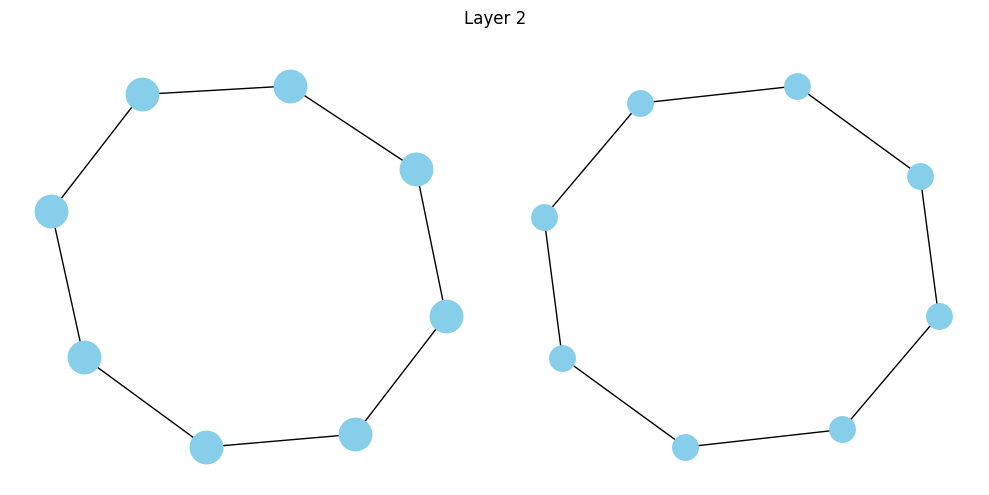

Largest Common Subgraph Size: 16
Max Common Subgraph Size: 8


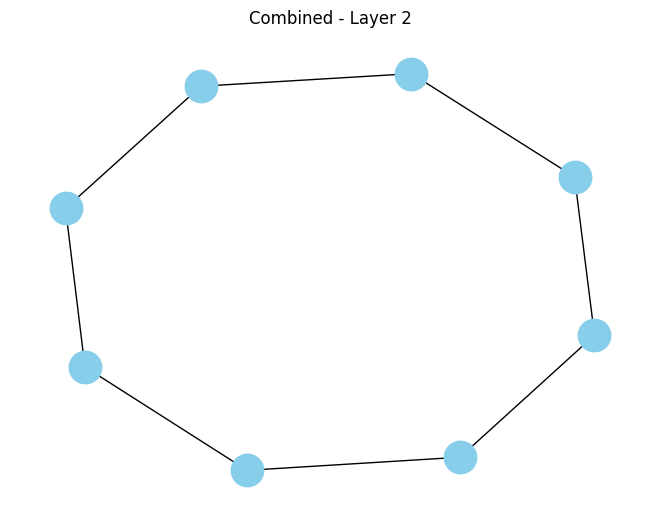

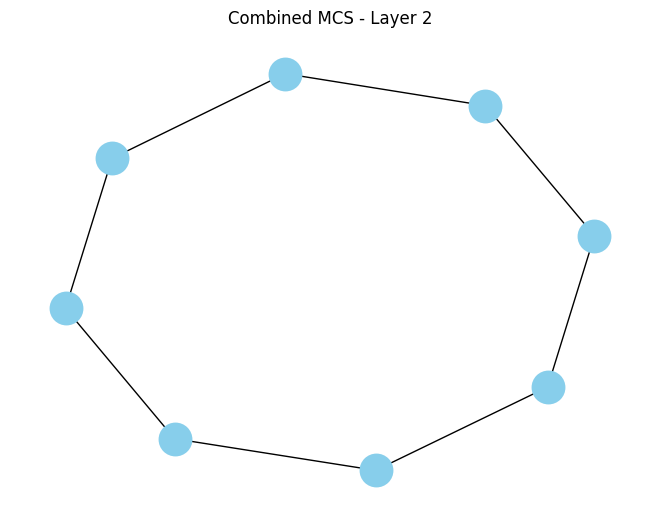

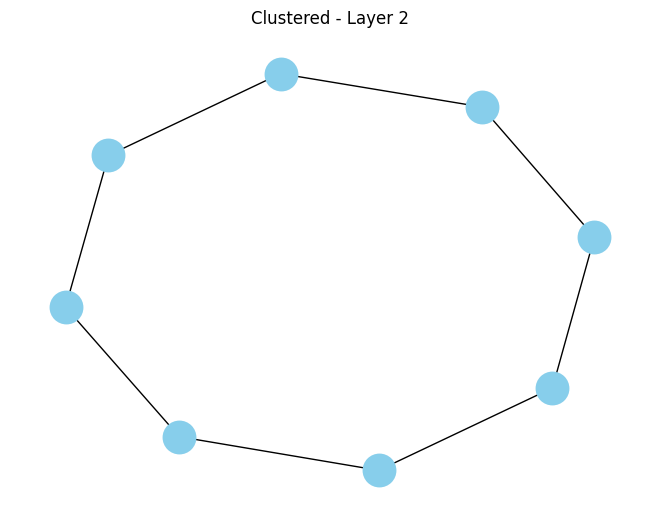

Layer 1 cross_attention_1 type: <class 'torch.Tensor'>
Layer 1 cross_attention_1 content: tensor([[ 0.5989, -0.6421, -0.5985,  0.6868,  0.6709, -0.6996,  0.6442,  0.6041,
         -0.6275, -0.6062, -0.6120, -0.5943,  0.6325, -0.6099,  0.7249, -0.6205,
         -0.5966, -0.6124,  0.7196, -0.6289,  0.6502, -0.7307, -0.6431, -0.6638,
          0.6595, -0.6525,  0.6081,  0.6999,  0.6573, -0.6617,  0.6964, -0.6992],
        [ 0.6258, -0.6708, -0.6253,  0.7143,  0.6977, -0.7276,  0.6729,  0.6311,
         -0.6556, -0.6333, -0.6393, -0.6209,  0.6607, -0.6372,  0.7540, -0.6482,
         -0.6234, -0.6396,  0.7485, -0.6570,  0.6791, -0.7601, -0.6718, -0.6904,
          0.6889, -0.6816,  0.6353,  0.7280,  0.6865, -0.6912,  0.7244, -0.7272],
        [ 0.6258, -0.6708, -0.6253,  0.7143,  0.6977, -0.7276,  0.6729,  0.6311,
         -0.6556, -0.6333, -0.6393, -0.6209,  0.6607, -0.6372,  0.7540, -0.6482,
         -0.6234, -0.6396,  0.7485, -0.6570,  0.6791, -0.7601, -0.6718, -0.6904,
          0.6889,

IndexError: The shape of the mask [8] at index 0 does not match the shape of the indexed tensor [21, 32] at index 0

In [233]:
def normalize_cross_attentions(attentions):
    if isinstance(attentions, torch.Tensor):
        return F.softmax(attentions, dim=-1)
    elif isinstance(attentions, list):
        normalized_list = [F.softmax(attn, dim=-1) for attn in attentions]
        return torch.stack(normalized_list)
    else:
        raise ValueError("Unsupported type for cross-attentions")


def extract_and_normalize_attentions(model, layer_idx):
    cross_attention_1 = model.layer_cross_attentions[layer_idx][0]
    cross_attention_2 = model.layer_cross_attentions[layer_idx][1]

    print(f"Layer {layer_idx} cross_attention_1 type: {type(cross_attention_1)}")
    print(f"Layer {layer_idx} cross_attention_1 content: {cross_attention_1}")
    print(f"Layer {layer_idx} cross_attention_2 type: {type(cross_attention_2)}")
    print(f"Layer {layer_idx} cross_attention_2 content: {cross_attention_2}")

    normalized_attention_1 = normalize_cross_attentions(cross_attention_1)
    normalized_attention_2 = normalize_cross_attentions(cross_attention_2)

    return normalized_attention_1, normalized_attention_2


def monitor_cross_attentions(combined_data, normalized_attentions, mcs_mapping):
    mcs_nodes = list(mcs_mapping.keys()) + list(mcs_mapping.values())
    mcs_nodes = list(set(mcs_nodes))  # Remove duplicates
    mcs_nodes_mask = torch.zeros(combined_data.x.size(0), dtype=torch.bool)
    mcs_nodes_mask[mcs_nodes] = True

    non_mcs_nodes_mask = ~mcs_nodes_mask

    if len(normalized_attentions.shape) == 3:
        # Handle list of tensors case
        normalized_attentions = normalized_attentions.view(
            -1, normalized_attentions.size(-1)
        )

    mcs_attentions = normalized_attentions[mcs_nodes_mask]
    non_mcs_attentions = normalized_attentions[non_mcs_nodes_mask]

    print("MCS Nodes Cross-Attentions:", mcs_attentions)
    print("Non-MCS Nodes Cross-Attentions:", non_mcs_attentions)


c = f"class_0"
idx1 = random.sample(range(len(classes[c])), 1)[0]
idx2 = random.sample(range(len(classes[c])), 1)[0]
graph1, graph2 = classes[c][idx1], classes[c][idx2]

model.eval()

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

accs = []
cs = []
clustered_graphs = []

k, k_1s, k_2s = best_k(model, 0.8)
print("Determined k:", k)
# k = 8

best_acc1, best_acc2 = 0.0, 0.0
cluster1, cluster2 = None, None
layer1, layer2 = None, None

layers = []
sims = []

for i in range(len(model.layer_outputs)):
    (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

    topk_pooling = TopKPooling(model.args.dim, ratio=8)

    x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
        x_1,
        edge_index_1,
    )
    x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
        x_2,
        edge_index_2,
    )

    acc1 = len(set(range(8)) & set(perm1.tolist()))
    acc2 = len(set(range(8)) & set(perm2.tolist()))

    layers.append(
        (
            (x_pooled_1, edge_index_pooled_1, score1),
            (x_pooled_2, edge_index_pooled_2, score2),
            i,
        )
    )

    clustered_graphs.append(
        (
            Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
            Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
        )
    )

    if acc1 > best_acc1:
        x = x_pooled_1
        cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
        best_acc1 = acc1
        layer1 = i + 1
    if acc2 > best_acc2:
        cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
        best_acc2 = acc2
        layer2 = i + 1

cs.append((layers, layer1, layer2))

accs.append(best_acc1)
accs.append(best_acc2)

connected_1 = []
connected_2 = []
connected_pairs = []
all_clusters = []

for i in range(len(clustered_graphs)):
    g1, g2 = clustered_graphs[i]
    k_1 = k_1s[i]
    k_2 = k_2s[i]
    if nx.is_connected(to_networkx(g1, to_undirected=True)):
        connected_1.append(g1)
    if nx.is_connected(to_networkx(g2, to_undirected=True)):
        connected_2.append(g2)

    if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
        to_networkx(g2, to_undirected=True)
    ):
        connected_pairs.append((g1, g2))
        print("k_1:", k_1, "k_2:", k_2)
        plot_graph_pair(g1, g2, title=f"Layer {i+1}")

        G1 = to_networkx(g1, to_undirected=True)
        G2 = to_networkx(g2, to_undirected=True)

        ismags = nx.isomorphism.ISMAGS(G1, G2)
        largest_common_subgraph = list(ismags.largest_common_subgraph(symmetry=False))

        print("Largest Common Subgraph Size:", len(largest_common_subgraph))

        mcs = max_common_subgraph(g1, g2)
        print("Max Common Subgraph Size:", len(mcs))

        combined_data = combine_graphs(g1, g2, largest_common_subgraph[0], ratio=1)
        combined_data_mcs = combine_graphs(g1, g2, mcs, ratio=1)

        plot_graph(combined_data, title=f"Combined - Layer {i+1}")
        plot_graph(combined_data_mcs, title=f"Combined MCS - Layer {i+1}")

        combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = topk_pooling(
            combined_data.x, combined_data.edge_index
        )

        combined_clustered = Data(
            x=combined_clustered_x, edge_index=combined_clustered_edge_index
        )

        plot_graph(combined_clustered, title=f"Clustered - Layer {i+1}")

        # Extract and normalize cross-attentions
        normalized_attentions_1, normalized_attentions_2 = (
            extract_and_normalize_attentions(model, i)
        )

        # Monitor cross-attentions
        print(f"Layer {i+1} Cross-Attentions for Combined Graph:")
        monitor_cross_attentions(
            combined_data, normalized_attentions_1, largest_common_subgraph[0]
        )
        monitor_cross_attentions(
            combined_data, normalized_attentions_2, largest_common_subgraph[0]
        )

        # Compute additional metrics
        ged = compute_ged(g1, g2)
        feature_similarity = compute_feature_similarity(g1.x, g2.x)
        attention_score = compute_attention_score(
            g1.x, g2.x
        )  # Replace with actual attention scores

        print(f"Layer {i+1} Metrics:")
        print("  GED:", ged)
        print("  Feature Similarity:", feature_similarity)
        print("  Attention Score:", attention_score)

    all_clusters.append(g1)
    all_clusters.append(g2)